# Generative models tutorial

In generative modelling, we have a dataset sampled from a probability distribution $X \sim P(X)$. We want to learn a model which can approximate this distribution.

In latent variable models, we assume that the factors of variation of the data are explained by hidden (latent) variables $Z$. At inference time, we can sample values of $Z$ and generate data by using our model to predict $P(X \vert Z)$.

First, create a dataset. We use the two moons dataset. 

(1000, 2) (1000,)


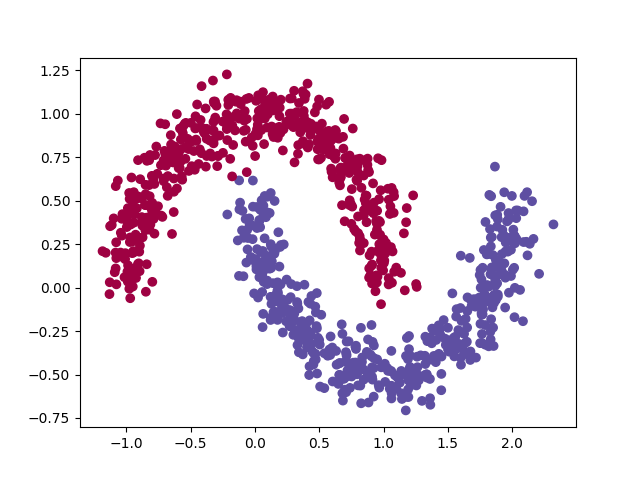

hello


In [57]:
import os
from PIL import Image
import sklearn.datasets as datasets
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

X, y = datasets.make_moons(n_samples=1000, noise=0.1)
print(X.shape, y.shape)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.savefig("outputs/moons.png")
plt.close()
Image.open("outputs/moons.png").show()

print("hello")

$\frac{dy}{dx}$